# 한글

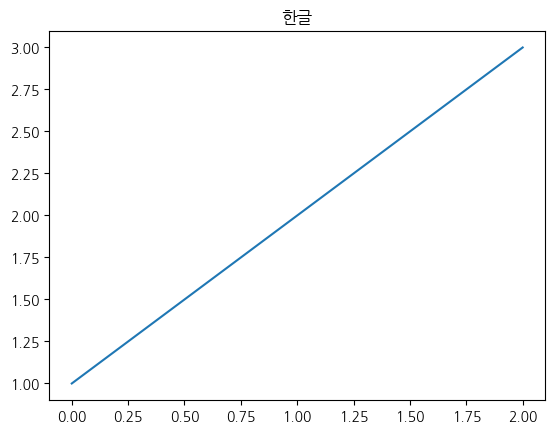

In [1]:
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

plt.rc("font", family="NanumGothic") # 라이브러리 불러오기와 함께 한번만 실행
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.plot([1, 2, 3])
plt.title("한글")
plt.show()

# 불러오기

In [2]:
# CSV 파일 불러오기
data = pd.read_csv('data/액체_모델용.csv')  # 'your_dataset.csv'에는 파일 경로와 이름을 적어주세요

In [3]:
data.columns

Index(['Datetime', 'ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호',
       '입항일시', '출항일시', '접안_대기시간_분', '출항_대기시간_분', 'Service_Time_Start',
       'Service_Time_End', '계선장소_코드', '계선장소_숫자', '계선장소명', '선박용도',
       'Service_Time_분', '대기율', '총톤수', '재화중량톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '만재흘수(m)', '깊이(m)', '길이1(m)', 'ETA_Minute', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)', '액체화물'],
      dtype='object')

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51001 entries, 0 to 51000
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Datetime            51001 non-null  object 
 1   ETA_Year            51001 non-null  int64  
 2   ETA_Month           51001 non-null  int64  
 3   ETA_Day             51001 non-null  int64  
 4   ETA_Hour            51001 non-null  int64  
 5   호출부호                51001 non-null  object 
 6   입항일시                51001 non-null  object 
 7   출항일시                51001 non-null  object 
 8   접안_대기시간_분           51001 non-null  int64  
 9   출항_대기시간_분           51001 non-null  float64
 10  Service_Time_Start  51001 non-null  object 
 11  Service_Time_End    51001 non-null  object 
 12  계선장소_코드             51001 non-null  object 
 13  계선장소_숫자             51001 non-null  int64  
 14  계선장소명               51001 non-null  object 
 15  선박용도                51001 non-null  object 
 16  Serv

In [5]:
# 두 칼럼을 합쳐 새로운 칼럼 생성
data['계선장소'] = data['계선장소_코드'].astype(str) + data['계선장소_숫자'].astype(str)

# '계선장소_코드'와 '계선장소_숫자컬럼' 칼럼 삭제
data = data.drop(['계선장소_코드', '계선장소_숫자'], axis=1)


# XGBoost 설치

In [6]:
!pip install xgboost


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# 베이스라인 코드

In [7]:
# 필요한 라이브러리 불러오기
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pandas as pd
import numpy as np

# 입력 변수와 타겟 변수 나누기
X = data[['총톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '깊이(m)', '길이1(m)', 'ETA_Hour', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)']]
y = data['접안_대기시간_분']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# XGBoost 모델 생성 및 학습
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제이므로 'reg:squarederror'를 사용
    max_depth=5,
    learning_rate=0.3,
    n_estimators=200
)

model.fit(X_train, y_train)

# 테스트 데이터에 대한 예측
y_pred = model.predict(X_test)

# RMSE 계산
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

# MAE 계산
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")

# 결정 계수(R-squared) 계산
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")

# 특성 중요도 출력
feature_importance = model.feature_importances_
feature_names = X.columns

print("Feature Importance:")
for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance}")


RMSE: 1116.969078207694
MAE: 548.2322071704745
R-squared: 0.023040318779233626
Feature Importance:
총톤수: 0.05147053673863411
선박제원(총길이, m): 0.0433955080807209
선박제원(너비, m): 0.13960358500480652
깊이(m): 0.058407653123140335
길이1(m): 0.054356638342142105
ETA_Hour: 0.05418167635798454
풍속(m/s): 0.0686124861240387
풍향(deg): 0.04281482473015785
GUST풍속(m/s): 0.04160956293344498
현지기압(hPa): 0.06763027608394623
습도(%): 0.04916463419795036
기온(°C): 0.043965116143226624
수온(°C): 0.04432656615972519
최대파고(m): 0.052622370421886444
유의파고(m): 0.04345255717635155
평균파고(m): 0.033965423703193665
파주기(sec): 0.054315414279699326
파향(deg): 0.05610506609082222


In [8]:
# 필요한 라이브러리 불러오기
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np

# 입력 변수와 타겟 변수 나누기
X = data[['총톤수', '선박제원(총길이, m)', '선박제원(너비, m)',
       '깊이(m)', '길이1(m)', 'ETA_Hour', '풍속(m/s)', '풍향(deg)',
       'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)', '최대파고(m)',
       '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)']]
y = data['접안_대기시간_분']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# XGBoost 모델 생성
model = xgb.XGBRegressor(
    objective='reg:squarederror',  # 회귀 문제이므로 'reg:squarederror'를 사용
    max_depth=5,
    learning_rate=0.3,
    n_estimators=200
)

# 10-fold 교차 검증 수행
scoring = 'neg_mean_squared_error'  # 단일 메트릭 선택

cv_results = cross_val_score(model, X, y, cv=10, scoring=scoring)

# 결과 출력
rmse = np.sqrt(-cv_results.mean())
print(f"RMSE: {rmse}")

# 특성 중요도 출력
model.fit(X_train, y_train)  # 전체 데이터로 모델 학습
feature_importance = model.feature_importances_
feature_names = X.columns

print("특성 중요도:")
for feature, importance in zip(feature_names, feature_importance):
    print(f"{feature}: {importance}")


RMSE: 1144.208956441329
특성 중요도:
총톤수: 0.05147053673863411
선박제원(총길이, m): 0.0433955080807209
선박제원(너비, m): 0.13960358500480652
깊이(m): 0.058407653123140335
길이1(m): 0.054356638342142105
ETA_Hour: 0.05418167635798454
풍속(m/s): 0.0686124861240387
풍향(deg): 0.04281482473015785
GUST풍속(m/s): 0.04160956293344498
현지기압(hPa): 0.06763027608394623
습도(%): 0.04916463419795036
기온(°C): 0.043965116143226624
수온(°C): 0.04432656615972519
최대파고(m): 0.052622370421886444
유의파고(m): 0.04345255717635155
평균파고(m): 0.033965423703193665
파주기(sec): 0.054315414279699326
파향(deg): 0.05610506609082222


# 최종 비교용 모델링

## 수정(참고내용)

In [9]:
import pandas as pd
# CSV 파일 불러오기
Final_D = pd.read_csv('data/for_ship_model.csv') 

In [10]:
Final_D.columns

Index(['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박제원(총길이, m)', '선박제원(너비, m)', '만재흘수(m)', '깊이(m)', '길이1(m)', '풍속(m/s)',
       '풍향(deg)', 'GUST풍속(m/s)', '현지기압(hPa)', '습도(%)', '기온(°C)', '수온(°C)',
       '최대파고(m)', '유의파고(m)', '평균파고(m)', '파주기(sec)', '파향(deg)', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded'],
      dtype='object')

In [15]:
Final_D.columns = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour', '호출부호', '접안_대기시간_분',
       '계선장소명', '선박용도', 'Service_Time_분', '대기율', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '선박_길이1', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온',
       '최대파고', '유의파고', '평균파고', '파주기', '파향', '이전_입항선박수',
       '연도별_선석점유율', '시설연평균_재화중량톤수', '연평균_총입항건수', '선박_연평균_서비스시간', '선박_연평균_대기시간',
       '호출부호_encoded', '계선장소명_encoded', '선박용도_encoded']

x_cols = ['ETA_Year', 'ETA_Month', 'ETA_Day', 'ETA_Hour',
       'Service_Time_분', '총톤수', '재화중량톤수',
       '선박_총길이', '선박_너비', '선박_만재흘수', '선박_깊이', '풍속',
       '풍향', 'GUST풍속', '현지기압', '습도', '기온', '수온', '최대파고', '유의파고', '평균파고',
        '파주기', '파향', '이전_입항선박수','시설연평균_재화중량톤수', 
        '연평균_총입항건수', '선박_연평균_서비스시간', '계선장소명_encoded', '선박용도_encoded']

## 모델링

RMSE: 1096.2605242253724
특성 중요도:


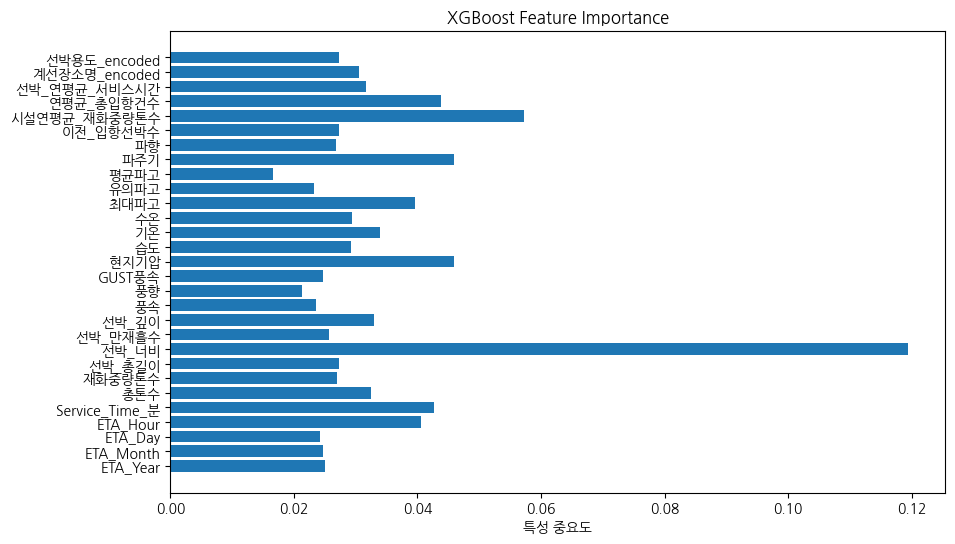

In [16]:
# 필요한 라이브러리 불러오기
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error # 추가: 결정계수 계산을 위한 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 추가: 시각화를 위한 모듈

# 입력 변수와 타겟 변수 나누기
X = Final_D[x_cols]
y = Final_D['접안_대기시간_분']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# XGBoost 모델 생성
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=5,
    learning_rate=0.3,
    n_estimators=200
)

# 10-fold 교차 검증 수행
scoring = 'neg_mean_squared_error'
cv_results = cross_val_score(model, X, y, cv=10, scoring=scoring)


# 결과 출력
rmse = np.sqrt(-cv_results.mean())
print(f"RMSE: {rmse}")

# 특성 중요도 출력
model.fit(X_train, y_train)
feature_importance = model.feature_importances_
feature_names = X.columns

print("특성 중요도:")

# 특성 중요도 시각화
plt.figure(figsize=(10, 6))
plt.barh(feature_names, feature_importance)
plt.xlabel('특성 중요도')
plt.title('XGBoost Feature Importance')
plt.show()


XGBoost RMSE: 1096.2605242253724
XGBoost MAE: 518.9263379848721
0:	learn: 1119.4830477	total: 4.69ms	remaining: 933ms
1:	learn: 1101.8128239	total: 8.44ms	remaining: 835ms
2:	learn: 1091.9156624	total: 11.6ms	remaining: 765ms
3:	learn: 1083.8384786	total: 14.9ms	remaining: 732ms
4:	learn: 1077.9298110	total: 18.8ms	remaining: 735ms
5:	learn: 1072.1840158	total: 22.2ms	remaining: 718ms
6:	learn: 1066.3880119	total: 25.7ms	remaining: 709ms
7:	learn: 1063.8085608	total: 29ms	remaining: 696ms
8:	learn: 1059.7066529	total: 32.1ms	remaining: 682ms
9:	learn: 1055.9184360	total: 35.6ms	remaining: 676ms
10:	learn: 1052.2660618	total: 39ms	remaining: 670ms
11:	learn: 1049.3620773	total: 42.1ms	remaining: 659ms
12:	learn: 1047.4363229	total: 45.5ms	remaining: 654ms
13:	learn: 1044.9504086	total: 49.1ms	remaining: 653ms
14:	learn: 1042.7722600	total: 52.5ms	remaining: 647ms
15:	learn: 1040.3904895	total: 56.4ms	remaining: 648ms
16:	learn: 1039.3864594	total: 59.6ms	remaining: 642ms
17:	learn: 1038

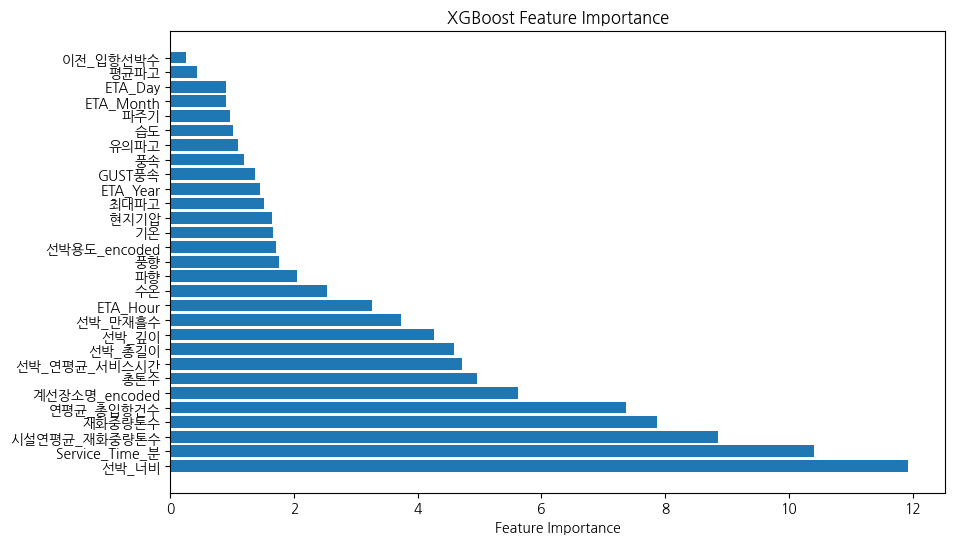

In [19]:
# 필요한 라이브러리 불러오기
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 추가: MAE 계산을 위한 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 추가: 시각화를 위한 모듈

# 추가: CatBoost 라이브러리 불러오기
from catboost import CatBoostRegressor

# 입력 변수와 타겟 변수 나누기
X = Final_D[x_cols]
y = Final_D['접안_대기시간_분']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# XGBoost 모델 생성
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=5,
    learning_rate=0.3,
    n_estimators=200
)

# 10-fold 교차 검증 수행
scoring = 'neg_mean_squared_error'
cv_results = cross_val_score(model_xgb, X, y, cv=10, scoring=scoring)

# 결과 출력
rmse = np.sqrt(-cv_results.mean())
print(f"XGBoost RMSE: {rmse}")

# 특성 중요도 출력
model_xgb.fit(X_train, y_train)
feature_importance_xgb = model_xgb.feature_importances_
feature_names_xgb = X.columns

# 이후에 MAE 계산을 위해 테스트 데이터에 대해 XGBoost 모델을 fit한 후 예측을 수행합니다.
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# MAE 계산
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")

# CatBoost 모델 생성
model_catboost = CatBoostRegressor(iterations=200, depth=5, learning_rate=0.3, loss_function='RMSE')

# CatBoost 모델 학습
model_catboost.fit(X_train, y_train)

# 추가: 피처 임포턴스 시각화
feature_importance_catboost = model_catboost.get_feature_importance()
feature_names_catboost = X.columns

feature_importance_dict_catboost = dict(zip(feature_names_catboost, feature_importance_catboost))

sorted_feature_importance_catboost = sorted(feature_importance_dict_catboost.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names_catboost, sorted_feature_importance_catboost = zip(*sorted_feature_importance_catboost)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names_catboost)), sorted_feature_importance_catboost, align='center')
plt.yticks(range(len(sorted_feature_names_catboost)), sorted_feature_names_catboost)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()


In [20]:
# 개인적으로 그냥 해보는 세 모델에서 TOP10에 공통적으로 들어가 있는?

In [27]:
fil_cols = ['Service_Time_분', '선박_연평균_서비스시간', '시설연평균_재화중량톤수', '총톤수', '선박_총길이',
          '재화중량톤수', '연평균_총입항건수', '선박_너비', '계선장소명_encoded']

XGBoost RMSE: 1094.2743790079098
XGBoost MAE: 500.05904011796395
0:	learn: 1119.9598476	total: 2.6ms	remaining: 518ms
1:	learn: 1103.2597029	total: 4.96ms	remaining: 491ms
2:	learn: 1091.5193469	total: 7.56ms	remaining: 496ms
3:	learn: 1084.3887993	total: 10.1ms	remaining: 496ms
4:	learn: 1079.4144577	total: 12.8ms	remaining: 501ms
5:	learn: 1074.3671295	total: 15.5ms	remaining: 500ms
6:	learn: 1069.9356399	total: 18.3ms	remaining: 505ms
7:	learn: 1067.4128625	total: 21.3ms	remaining: 512ms
8:	learn: 1064.8703434	total: 25.2ms	remaining: 536ms
9:	learn: 1063.0584410	total: 27.7ms	remaining: 526ms
10:	learn: 1059.9244579	total: 30ms	remaining: 515ms
11:	learn: 1056.4331395	total: 32.2ms	remaining: 504ms
12:	learn: 1055.4174049	total: 34.7ms	remaining: 499ms
13:	learn: 1053.8139986	total: 37.2ms	remaining: 495ms
14:	learn: 1050.8895892	total: 39.5ms	remaining: 487ms
15:	learn: 1048.9996997	total: 41.5ms	remaining: 477ms
16:	learn: 1047.4649709	total: 44.3ms	remaining: 477ms
17:	learn: 10

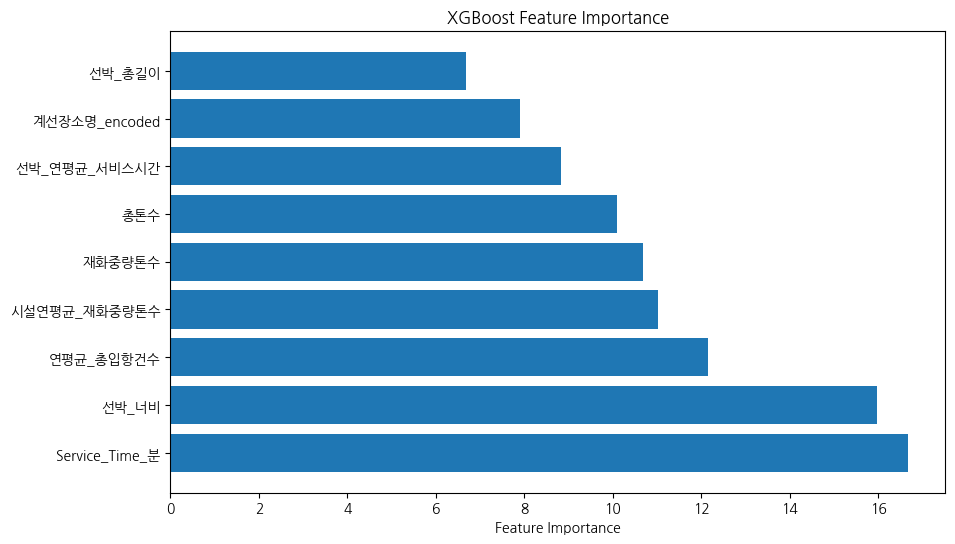

In [28]:
# 필요한 라이브러리 불러오기
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error  # 추가: MAE 계산을 위한 모듈
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  # 추가: 시각화를 위한 모듈

# 추가: CatBoost 라이브러리 불러오기
from catboost import CatBoostRegressor

# 입력 변수와 타겟 변수 나누기
X = Final_D[fil_cols]
y = Final_D['접안_대기시간_분']

# 데이터를 학습용과 테스트용으로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

# XGBoost 모델 생성
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    max_depth=5,
    learning_rate=0.3,
    n_estimators=200
)

# 10-fold 교차 검증 수행
scoring = 'neg_mean_squared_error'
cv_results = cross_val_score(model_xgb, X, y, cv=10, scoring=scoring)

# 결과 출력
rmse = np.sqrt(-cv_results.mean())
print(f"XGBoost RMSE: {rmse}")

# 특성 중요도 출력
model_xgb.fit(X_train, y_train)
feature_importance_xgb = model_xgb.feature_importances_
feature_names_xgb = X.columns

# 이후에 MAE 계산을 위해 테스트 데이터에 대해 XGBoost 모델을 fit한 후 예측을 수행합니다.
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

# MAE 계산
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
print(f"XGBoost MAE: {mae_xgb}")

# CatBoost 모델 생성
model_catboost = CatBoostRegressor(iterations=200, depth=5, learning_rate=0.3, loss_function='RMSE')

# CatBoost 모델 학습
model_catboost.fit(X_train, y_train)

# 추가: 피처 임포턴스 시각화
feature_importance_catboost = model_catboost.get_feature_importance()
feature_names_catboost = X.columns

feature_importance_dict_catboost = dict(zip(feature_names_catboost, feature_importance_catboost))

sorted_feature_importance_catboost = sorted(feature_importance_dict_catboost.items(), key=lambda x: x[1], reverse=True)
sorted_feature_names_catboost, sorted_feature_importance_catboost = zip(*sorted_feature_importance_catboost)

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_feature_names_catboost)), sorted_feature_importance_catboost, align='center')
plt.yticks(range(len(sorted_feature_names_catboost)), sorted_feature_names_catboost)
plt.xlabel('Feature Importance')
plt.title('XGBoost Feature Importance')
plt.show()
